## MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784')

In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [29]:
type(some_digit)

pandas.core.series.Series

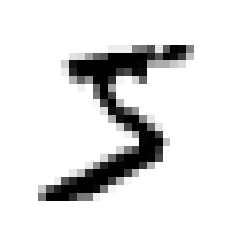

In [48]:
# visualize random digit
from matplotlib import pyplot as plt
import numpy as np

X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
some_digit = mnist['data'].iloc[0]
some_digit_image = some_digit.values.reshape((28, 28))

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [49]:
# train/test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train SGD

In [50]:
# target: 5
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/Users/dvorasindmitrij/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance measures

### Accuracy with CV

In [58]:
# write my own cross-validation and get accuracy
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3)

for train_index, test_index in skfold.split(X_train, y_train_5):
    clf_clone = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clf_clone.fit(X_train_folds, y_train_folds)
    results = clf_clone.predict(X_test_fold)
    
    print(sum(results == y_test_fold)/len(results))

0.95035
0.96035
0.9604


In [65]:
# check accuracy of SGD with cross_val_score
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [79]:
# create class of always predicting 0, check its accuracy
from sklearn.base import BaseEstimator

class Never5(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype='bool')

In [80]:
never_5 = Never5()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [82]:
# build confusion matrix with cross_val_predict
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_pred_5)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [93]:
print('Precision: ' + str(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][1])))
print('Recall: ' + str(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][0])))

Precision: 0.8370879772350012
Recall: 0.06147469610950507


In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_pred_5))
print(recall_score(y_train_5, y_pred_5))
print(f1_score(y_train_5, y_pred_5))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [99]:
# get scores instead of prediction classes
y_scores_5 = cross_val_predict(sgd_clf, X_train, y_train_5, method='decision_function')

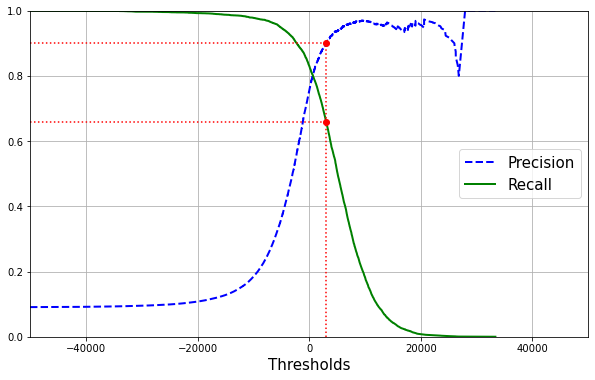

In [199]:
# plot precision and recall as 2 lines
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_5)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], 'b--', linewidth=2, label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', linewidth=2, label='Recall')
plt.legend(loc='center right', fontsize=15)

# get recall of 90% precision with argmax
recall_with_90_pr = recalls[np.argmax(precisions >= 0.9)]
threshold_with_90_pr = thresholds[np.argmax(precisions >= 0.9)]

plt.plot([threshold_with_90_pr, threshold_with_90_pr], [0., 0.9], 'r:') # vertical red line
plt.plot([-50000, threshold_with_90_pr], [0.9, 0.9], 'r:') # horizontal upper line
plt.plot([-50000, threshold_with_90_pr], [recall_with_90_pr, recall_with_90_pr], 'r:') # horizontal lower line
plt.plot([threshold_with_90_pr], [0.9], 'ro')
plt.plot([threshold_with_90_pr], [recall_with_90_pr], 'ro')
plt.xlim([-50000, 50000])
plt.ylim([0, 1])
plt.xlabel('Thresholds', fontsize=15)
plt.grid(visible=True)
plt.show()

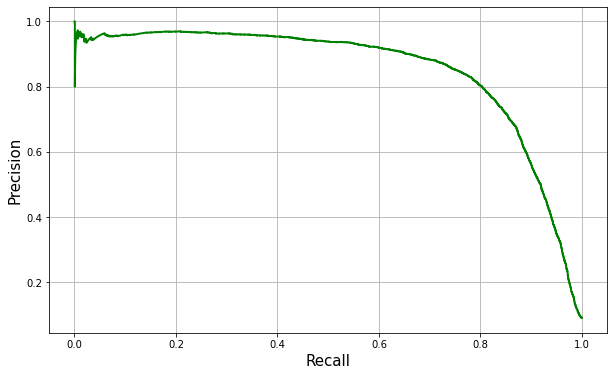

In [233]:
# plot precision vs recall
plt.figure(figsize=(10,6))
plt.plot(recalls[:-1], precisions[:-1], 'g-', linewidth=2)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.grid(visible=True)
plt.show()

In [203]:
y_pred_5_90pr = (y_scores_5 >= threshold_with_90_pr)
print(precision_score(y_train_5, y_pred_5_90pr))
print(recall_score(y_train_5, y_pred_5_90pr))

0.9002016129032258
0.6589190186312488


### ROC

In [223]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest_5 = cross_val_predict(forest_clf, X_train, y_train_5, method='predict_proba')

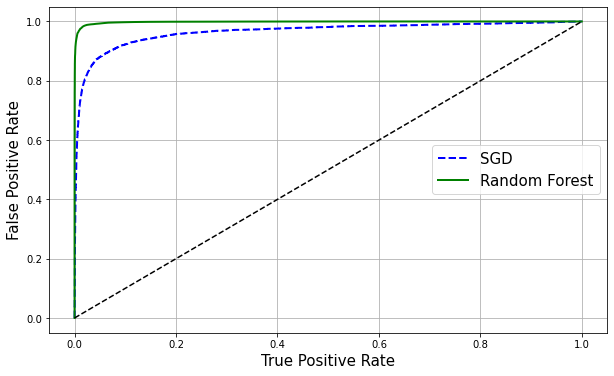

In [238]:
# plot ROC-graphs of sgd and random forest classifiers
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_5, y_scores_5)
plt.plot(fpr_sgd, tpr_sgd, 'b--', linewidth=2, label='SGD')

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_proba_forest_5[:, 1])
plt.plot(fpr_forest, tpr_forest, 'g-', linewidth=2, label='Random Forest')

plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
plt.grid(True)
plt.legend(loc='center right', fontsize=15)
plt.xlabel('True Positive Rate', fontsize=15)
plt.ylabel('False Positive Rate', fontsize=15)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.show()

In [231]:
# roc auc
from sklearn.metrics import roc_auc_score
roc_auc_sgd = roc_auc_score(y_train_5, y_scores_5)
roc_auc_forest = roc_auc_score(y_train_5, y_proba_forest_5[:, 1])
print('SGD ROC AUC: ' + str(roc_auc_sgd))
print('Random Forest ROC AUC: ' + str(roc_auc_forest))

SGD ROC AUC: 0.9648211175804801
Random Forest ROC AUC: 0.998402186461512
